In [18]:
import pvlib

import pandas as pd

import matplotlib.pyplot as plt

import pvlib.pvsystem as pvsystem


coordinates = [(47.4, 8.54, 'Zurich-ETZ', 550, 'Etc/GMT-1')]

sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

inverter = sawpm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

In [19]:
tmys = []

for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude,map_variables=True)[0]
    weather.index.name = "utc_time"
    tmys.append(weather)

Zurich-ETZ    265831.905529
dtype: float64


Text(0, 0.5, 'Yearly energy yield (W hr)')

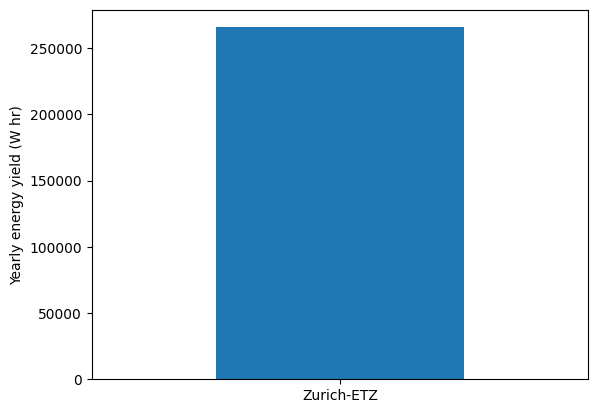

In [20]:
system = {'module': module, 'inverter': inverter,'surface_azimuth': 180, 'surface_tilt':20}

energies = {}


for location, weather in zip(coordinates, tmys):
    latitude, longitude, name, altitude, timezone = location
    system['surface_tilt'] = latitude
    solpos = pvlib.solarposition.get_solarposition(
        time=weather.index,
        latitude=latitude,
        longitude=longitude,
        altitude=altitude,
        temperature=weather["temp_air"],
        pressure=pvlib.atmosphere.alt2pres(altitude),
    )
    dni_extra = pvlib.irradiance.get_extra_radiation(weather.index)
    airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
    pressure = pvlib.atmosphere.alt2pres(altitude)
    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
    aoi = pvlib.irradiance.aoi(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos["apparent_zenith"],
        solpos["azimuth"],
    )
    total_irradiance = pvlib.irradiance.get_total_irradiance(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos['apparent_zenith'],
        solpos['azimuth'],
        weather['dni'],
        weather['ghi'],
        weather['dhi'],
        dni_extra=dni_extra,
        model='haydavies',
    )
    cell_temperature = pvlib.temperature.sapm_cell(
        total_irradiance['poa_global'],
        weather["temp_air"],
        weather["wind_speed"],
        **temperature_model_parameters,
    )
    effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
        total_irradiance['poa_direct'],
        total_irradiance['poa_diffuse'],
        am_abs,
        aoi,
        module,
    )
    dc = pvlib.pvsystem.sapm(effective_irradiance, cell_temperature, module)
    ac = pvlib.inverter.sandia(dc['v_mp'], dc['p_mp'], inverter)
    annual_energy = ac.sum()
    energies[name] = annual_energy


energies = pd.Series(energies)


print(energies)






energies.plot(kind='bar', rot=0)


plt.ylabel('Yearly energy yield (W hr)')
